# Dy164 uncertainty propagation


Before this notebook is run on a new system, make sure to compile the Cython files by doing (in the top repo directory):

```python setup.py build_ext --inplace```

In [1]:
%load_ext autoreload


import matplotlib.pyplot as plt
import numpy as np
import sys, os
sys.path.insert(0, "../../")
import ompy as om
import copy
%autoreload 2


import matplotlib as mpl
#mpl.style.use('article')

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
rc('errorbar', capsize=1.5) # Set error bar style


%matplotlib notebook


/home/jorgenem/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/jorgenem/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/jorgenem/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


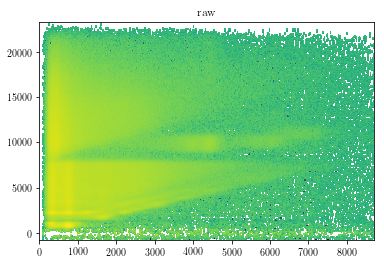

In [2]:
# Import raw matrix into instance of om.Matrix() and plot it
fname_raw = "data/alfna"
raw = om.Matrix()
raw.load(fname_raw)
raw.plot(title="raw", zscale="log")

In [ ]:
raw.calibration()

In [ ]:
# Cut away diagonal
Ex1 = 0
Eg1 = 800
E1 = [Ex1, Eg1]
Ex2 = 7300
Eg2 = 7800
E2 = [Ex2, Eg2]
#raw_diagcut = copy.copy(raw)
#raw_diagcut.matrix = om.cut_diagonal(raw.matrix, raw.E0_array, raw.E1_array, E1, E2)
raw.cut_diagonal(E1, E2)
raw.plot(zscale="log")

In [ ]:
# Drop Ex larger than Sn, about 8300 keV
raw.cut_rect(axis=0, E_limits=[0, 8400])
raw.plot()

In [ ]:
# Put it into an instance of om.MatrixAnalysis() to do unfolding and first generation method:
ma = om.MatrixAnalysis()
ma.raw = raw
ma.raw.plot()

In [ ]:
# Unfold the matrix. 
# I haven't implemented a fast enough routine for response function interpolation yet,
# so we have to load response functions with the right calibration, made by MAMA, from file.
fname_resp_mat = "data/response_matrix.m"
fname_resp_dat = "data/resp.dat"

# Call the unfolding algorithm:
diag_cut = {"Ex1": 0, "Eg1": 800, "Ex2": 7300, "Eg2": 7800}
ma.unfold(fname_resp_dat=fname_resp_dat, fname_resp_mat=fname_resp_mat, diag_cut=diag_cut,
          fill_and_remove_negative=True)
# The result is stored in the Matrix() instance ma.unfolded. Plot it:
ma.unfolded.plot()

In [ ]:
# Run first generation method
ma.first_generation_method(Ex_max = 8500, dE_gamma = 500,
                           fill_and_remove_negative=True)
ma.firstgen.plot(zmin=1e-3)

In [ ]:
# Plot them all together

f, (axraw, axunf, axfg) = plt.subplots(1, 3, sharey=True)

# Plot raw:
cbar_raw = ma.raw.plot(ax=axraw)
f.colorbar(cbar_raw, ax=axraw)

# Plot unfolded:
cbar_unf = ma.unfolded.plot(ax=axunf)
f.colorbar(cbar_unf, ax=axunf)

# Plot firstgen:
cbar_fg = ma.firstgen.plot(ax=axfg)
f.colorbar(cbar_fg, ax=axfg)


# Add axis labels and titles
axraw.set_title("(a) raw")
axunf.set_title("(b) unfolded")
axfg.set_title("(c) first generation")

axraw.set_ylabel(r"$E_x \,\,\mathrm{(keV)}$")

axraw.set_xlabel(r"$E_\gamma \,\,\mathrm{(keV)}$")
axunf.set_xlabel(r"$E_\gamma \,\,\mathrm{(keV)}$")
axfg.set_xlabel(r"$E_\gamma \,\,\mathrm{(keV)}$")



f.set_size_inches((10, 5))
plt.tight_layout(True)


plt.savefig("Dy164-matrices_raw_unf_fg.png")

plt.show()

In [ ]:
# Do error propagation in order to obtain an error matrix on the first generation spectrum
# Note that it requires an instance of MatrixAnalysis as input
N_ensemble = 100
ep = om.ErrorPropagation(ma, folder="error_propagation_ensemble", random_seed=481516)
ep.generate_ensemble(N_ensemble_members=N_ensemble, randomness="poisson", purge_files=False)

In [ ]:
f, (axraw, axunf, axfg) = plt.subplots(1, 3, sharey=True)

# Fetch and plot the standard deviation of raw:
std_raw = ep.std_raw
cbar_raw = std_raw.plot(ax=axraw)
f.colorbar(cbar_raw, ax=axraw)

# Fetch and plot the standard deviation of unfolded:
std_unfolded = ep.std_unfolded
cbar_unf = std_unfolded.plot(ax=axunf)
f.colorbar(cbar_unf, ax=axunf)

# Fetch and plot the standard deviation of firstgen:
std_firstgen = ep.std_firstgen
cbar_fg = std_firstgen.plot(ax=axfg)
f.colorbar(cbar_fg, ax=axfg)


# Add axis labels and titles
axraw.set_title("(a) raw")
axunf.set_title("(b) unfolded")
axfg.set_title("(c) first generation")

axraw.set_ylabel(r"$E_x \,\,\mathrm{(keV)}$")

axraw.set_xlabel(r"$E_\gamma \,\,\mathrm{(keV)}$")
axunf.set_xlabel(r"$E_\gamma \,\,\mathrm{(keV)}$")
axfg.set_xlabel(r"$E_\gamma \,\,\mathrm{(keV)}$")



f.set_size_inches((10, 5))
plt.tight_layout(True)


plt.savefig("Dy164-matrices_std_raw_unf_fg.png")

plt.show()

In [ ]:
# For paper and PhD thesis: Plot both counts and std matrices together, with common colorbars
from matplotlib.colors import LogNorm

f, ((axraw, axunf, axfg),(axraw_std, axunf_std, axfg_std)) = plt.subplots(2, 3, sharey=True, sharex=True)


raw = ma.raw
unfolded = ma.unfolded
firstgen = ma.firstgen

std_raw = ep.std_raw
std_unfolded = ep.std_unfolded
std_firstgen = ep.std_firstgen
# Common vmin, vmax for all three std matrices:
min_threshold = 1e-1
vmin = np.min((raw.matrix.min(), unfolded.matrix.min(), firstgen.matrix.min(),
               std_raw.matrix.min(), std_unfolded.matrix.min(), std_firstgen.matrix.min()))
vmin = max(vmin, min_threshold)
vmax = np.max((raw.matrix.max(), unfolded.matrix.max(), firstgen.matrix.max(),
               std_raw.matrix.max(), std_unfolded.matrix.max(), std_firstgen.matrix.max()))


# === Plot counts matrices: ===
# Fetch and plot the standard deviation of raw:
cbar_raw = axraw.pcolormesh(raw.E1_array, raw.E0_array, raw.matrix,
                                norm=LogNorm(vmin=vmin, vmax=vmax))
#f.colorbar(cbar_raw_std, ax=axraw_std)

# Fetch and plot the standard deviation of unfolded:
cbar_unf = axunf.pcolormesh(unfolded.E1_array, unfolded.E0_array, unfolded.matrix,
                               norm=LogNorm(vmin=vmin, vmax=vmax))
#f.colorbar(cbar_unf_std, ax=axunf_std)

# Fetch and plot the standard deviation of firstgen:
cbar_fg = axfg.pcolormesh(firstgen.E1_array, firstgen.E0_array, firstgen.matrix,
                               norm=LogNorm(vmin=vmin, vmax=vmax))


# === Plot std matrices: ===

# Fetch and plot the standard deviation of raw:
cbar_raw = axraw_std.pcolormesh(std_raw.E1_array, std_raw.E0_array, std_raw.matrix,
                                norm=LogNorm(vmin=vmin, vmax=vmax))
#f.colorbar(cbar_raw_std, ax=axraw_std)

# Fetch and plot the standard deviation of unfolded:
cbar_unf_std = axunf_std.pcolormesh(std_unfolded.E1_array, std_unfolded.E0_array, std_unfolded.matrix,
                               norm=LogNorm(vmin=vmin, vmax=vmax))
#f.colorbar(cbar_unf_std, ax=axunf_std)

# Fetch and plot the standard deviation of firstgen:
cbar_fg_std = axfg_std.pcolormesh(std_firstgen.E1_array, std_firstgen.E0_array, std_firstgen.matrix,
                               norm=LogNorm(vmin=vmin, vmax=vmax))
#f.colorbar(cbar_fg_std, ax=axfg_std, cax=cbax_std)



# Add colorbar, common between all plots

f.subplots_adjust(left=0.1, right=0.9, hspace=0.13)
cbax = f.add_axes([0.92, 0.1, 0.03, 0.8])
f.colorbar(cbar_raw, cax=cbax)


# Add axis labels and titles
axraw.set_title("(a) raw")
axunf.set_title("(b) unfolded")
axfg.set_title("(c) first generation")

axraw_std.set_title("(d) $\sigma_\mathrm{raw}$")
axunf_std.set_title("(e) $\sigma_\mathrm{unfolded}$")
axfg_std.set_title("(f) $\sigma_\mathrm{first\,\, generation}$")

axraw.set_ylabel(r"$E_x \,\,\mathrm{(keV)}$")
axraw_std.set_ylabel(r"$E_x \,\,\mathrm{(keV)}$")

axraw_std.set_xlabel(r"$E_\gamma \,\,\mathrm{(keV)}$")
axunf_std.set_xlabel(r"$E_\gamma \,\,\mathrm{(keV)}$")
axfg_std.set_xlabel(r"$E_\gamma \,\,\mathrm{(keV)}$")



f.set_size_inches((8, 8))


plt.savefig("Dy164-matrices_all_six.png", dpi=300)

plt.show()

# Fit rho and T 

In [ ]:
import time
bin_width_out = 120 #150
Ex_min = 4000
Ex_max = 8000
Eg_min = 1000

ftol = 1e-3 # Fitting tolerance (in some unknown, relative units)
maxfev = None # maximum number of function evaluations

#rho, T = om.fit_rho_T(ma.firstgen, firstgen_std, bin_width_out,
start = time.time()
fits = om.FitRhoT(ma.firstgen, std_firstgen, bin_width_out,
                      Ex_min, Ex_max, Eg_min,
                      method="Powell",
                      options={'disp':True, 'ftol':ftol, 'maxfev':maxfev}
                      #error_normalization="approximate"
                     )



fits.fit()


stop = time.time()
print("fit took", stop-start, "s")
rho = fits.rho
T = fits.T

In [ ]:
f, (axrho, axgsf) = plt.subplots(2,1)
rho.plot(ax=axrho, yscale="log")
#T.plot(ax=axT, yscale="log")
gsf = om.Vector(E_array=T.E_array, vector=om.div0(T.vector, T.E_array**3))
gsf.plot(ax=axgsf, yscale="log")


axrho.set_title(r"(a) Level density $\rho$")
axgsf.set_title(r"(b) $\gamma$SF $f$")

axrho.set_ylabel("arb. units")
axgsf.set_ylabel("arb. units")

axrho.set_xlabel(r"$E_x (\mathrm{MeV})$")
axgsf.set_xlabel(r"$E_\gamma (\mathrm{MeV})$")


f.set_size_inches(4,6)
plt.tight_layout(True)
f.savefig("Dy164_rho_and_gsf_raw_fit.pdf")

plt.show()

In [ ]:
# Play with alpha parameter
alpha = 0.002

f, (axrho, axgsf) = plt.subplots(1,2)
rho.transform(alpha=alpha, inplace=False).plot(ax=axrho, yscale="log")
#T.plot(ax=axT, yscale="log")
gsf = om.Vector(E_array=T.E_array, vector=om.div0(T.vector, T.E_array**3))
gsf.transform(alpha=alpha, inplace=False).plot(ax=axgsf, yscale="log")

plt.tight_layout(True)
plt.show()

In [ ]:
# Fit the whole error ensemble using their common error matrix; use spread as gauge for uncert
# We replace the firstgen matrix of "ma_curr" every iteration.
ma_curr = copy.deepcopy(ma)

N_ensemble_fit = 100
if N_ensemble_fit > N_ensemble:
    raise ValueError("Not enough ensemble members")

try:
    # Load ensemble members of rho and T fits
    rho_ens = np.loadtxt("error_propagation_ensemble/rho_ensemble_fits-{:d}-bin_width_{:d}-ftol_{:.0e}.txt".format(N_ensemble_fit, bin_width_out, ftol))
    T_ens = np.loadtxt("error_propagation_ensemble/T_ensemble_fits-{:d}-bin_width_{:d}-ftol_{:.0e}.txt".format(N_ensemble_fit, bin_width_out, ftol))
    
except:
    rho_ens = np.zeros((N_ensemble_fit, len(rho.vector)))
    T_ens = np.zeros((N_ensemble_fit, len(T.vector)))
    for i_ens in range(N_ensemble_fit):
        print("Fitting ensemble member {:d}".format(i_ens))
        ma_curr.firstgen.matrix = ep.firstgen_ensemble[i_ens, :, :]
        ma_curr.firstgen.matrix[ma_curr.firstgen.matrix < 0] = 0
        #ma.firstgen.plot()
        
        start = time.time()
        
        fits_curr = om.FitRhoT(ma_curr.firstgen, std_firstgen, bin_width_out,
                          Ex_min, Ex_max, Eg_min,
                          method="Powell",
                          options={'disp':True, 'ftol':ftol, 'maxfev':maxfev}
                         )
        fits_curr.fit(p0=np.append(rho.vector, T.vector))
        
        stop = time.time()
        print("fit took", stop-start, "s")
        
        rho_curr= fits_curr.rho
        T_curr = fits_curr.T
        rho_ens[i_ens, :] = rho_curr.vector
        T_ens[i_ens, :] = T_curr.vector
    # Save ensemble members of rho and T fits

    np.savetxt("error_propagation_ensemble/rho_ensemble_fits-{:d}-bin_width_{:d}-ftol_{:.0e}.txt".format(N_ensemble_fit, bin_width_out, ftol), rho_ens)
    np.savetxt("error_propagation_ensemble/T_ensemble_fits-{:d}-bin_width_{:d}-ftol_{:.0e}.txt".format(N_ensemble_fit, bin_width_out, ftol), T_ens)

In [ ]:
## for consistency in the plots below, uncomment these lines
## set the vector elements as the mean
# rho.vector = rho_ens.mean(axis=0) # Added by Fabio
# T.vector = T_ens.mean(axis=0) # Added by Fabio

In [ ]:
# Plot with uncertainties
alpha=0.0020
A = 1.0
B = 2*np.pi*1.3

color="teal"

f, ((axrho_raw, axgsf_raw), (axrho_transf, axgsf_transf)) = plt.subplots(2, 2, sharex=True)

rho_std = om.Vector(vector=np.std(rho_ens, axis=0), E_array=rho.E_array)
axrho_raw.errorbar(rho.E_array, rho.vector, yerr=rho_std.vector,
                   label=r"$\rho$, raw fit", fmt=".", markersize=2, capsize=1, color=color)
#axrho_raw.set_title("rho, raw fit")
axrho_raw.legend()
axrho_raw.set_yscale("log")
#axrho_raw.set_xlim([0, rho.E_array.max()])

axrho_transf.errorbar(rho.E_array, rho.transform(const=A, alpha=alpha).vector,
                      yerr=rho_std.transform(const=A, alpha=alpha).vector,
                      label=r"$\rho$, transformed", fmt=".", markersize=1, capsize=1, color=color)

# Load and add published, normalized data:
#rho_published = np.loadtxt("data/rho164dy-nyhus.txt", skiprows=2)
rho_published = np.loadtxt("data/nld_164Dy_3He_3He_164Dy.txt", skiprows=6)
rho_published[:, 0] *= 1000
axrho_transf.errorbar(rho_published[:, 0], rho_published[:, 1], yerr=rho_published[:, 2],
                      fmt="<", markersize=2, color="crimson",
                      label=r"$\rho$, Nyhus $\textit{et\,\,al.}$")

#axrho_transf.set_title("rho, transformed")
axrho_transf.legend()
axrho_transf.set_yscale("log")
#axrho_transf.set_xlim([0, rho.E_array.max()])

T_std = om.Vector(vector=np.std(T_ens, axis=0), E_array=T.E_array)

# Convert T to gsf
gsf = om.Vector(E_array=T.E_array, vector=om.div0(T.vector, 2*np.pi*T.E_array**3))
gsf_std = om.Vector(E_array=T_std.E_array, vector=om.div0(T_std.vector, 2*np.pi*T_std.E_array**3))

axgsf_raw.errorbar(gsf.E_array, gsf.vector, yerr=gsf_std.vector,
                   label="$\gamma$SF, raw fit", fmt=".", markersize=1, capsize=1, color=color)
#axgsf_raw.set_title("gsf, raw fit")
axgsf_raw.legend()
axgsf_raw.set_yscale("log")


axgsf_transf.errorbar(gsf.E_array, gsf.transform(const=B, alpha=alpha).vector,
                      yerr=gsf_std.transform(const=B, alpha=alpha).vector, label=r"$\gamma$SF, transformed",
                      fmt="o", markersize=2, capsize=1, color=color)

# Load and add published, normalized data:
#gsf_published = np.loadtxt("data/rsf164dy.txt", skiprows=2)
gsf_published = np.loadtxt("data/gsf_164Dy_3He_3He_164Dy.txt", skiprows=6)
gsf_published[:, 0] *= 1000
axgsf_transf.errorbar(gsf_published[:, 0], gsf_published[:, 1], yerr=gsf_published[:, 2],
                      fmt="<", markersize=2, color="crimson",
                      label=r"$\gamma$SF, Nyhus $\textit{et\,\,al.}$")

#axgsf_transf.set_title("gsf, transformed")
axgsf_transf.legend()
axgsf_transf.set_yscale("log")

# Axis labels
axrho_raw.set_ylabel("arb. units")
axgsf_raw.set_ylabel("arb. units")

axrho_transf.set_ylabel(r"$\rho \,\, (\mathrm{MeV}^{-1})$")
axgsf_transf.set_ylabel(r"$f_1 \,\, (\mathrm{MeV}^{-3})$")

axrho_transf.set_xlabel(r"$E_x (\mathrm{MeV})$")
axgsf_transf.set_xlabel(r"$E_\gamma (\mathrm{MeV})$")

plt.tight_layout(True)

f.savefig("Dy164_rho_and_T_fit_and_alpha_transform.pdf")

plt.show()

In [ ]:
# Plot with uncertainties, only the transformed versions

color="teal"

f, (axrho_transf, axgsf_transf) = plt.subplots(2, 1)

rho_std = om.Vector(vector=np.std(rho_ens, axis=0), E_array=rho.E_array)

axrho_transf.errorbar(rho.E_array, rho.transform(const=A, alpha=alpha).vector,
                      yerr=rho_std.transform(const=A, alpha=alpha).vector,
                      label=r"$\rho$, present", fmt="o", markersize=2, capsize=1,
                      linewidth=0.8, color=color)

# Load and add published, normalized data:
#rho_published = np.loadtxt("data/rho164dy.txt", skiprows=2)
rho_published = np.loadtxt("data/nld_164Dy_3He_3He_164Dy.txt", skiprows=6)
rho_published[:, 0] *= 1000
axrho_transf.errorbar(rho_published[:, 0], rho_published[:, 1], yerr=rho_published[:, 2],
                      fmt="<", markersize=2, color="slateblue", linewidth=0.8,
                      label=r"$\rho$, Renstr{\o}m $\textit{et\,\,al.}$")

#axrho_transf.set_title("rho, transformed")
axrho_transf.legend()
axrho_transf.set_yscale("log")

T_std = om.Vector(vector=np.std(T_ens, axis=0), E_array=T.E_array)

# Convert T to gsf
gsf = om.Vector(E_array=T.E_array, vector=om.div0(T.vector, 2*np.pi*T.E_array**3))
gsf_std = om.Vector(E_array=T_std.E_array, vector=om.div0(T_std.vector, 2*np.pi*T_std.E_array**3))



axgsf_transf.errorbar(gsf.E_array[3:], gsf.transform(const=B, alpha=alpha).vector[3:],
                      yerr=gsf_std.transform(const=B, alpha=alpha).vector[3:],
                      label=r"$\gamma$SF, present", linewidth=0.8,
                      fmt="o", markersize=2, capsize=1, color=color)

# Load and add published, normalized data:
#gsf_published = np.loadtxt("data/rsf164dy.txt", skiprows=2)
gsf_published = np.loadtxt("data/gsf_164Dy_3He_3He_164Dy.txt", skiprows=6)
gsf_published[:, 0] *= 1000
axgsf_transf.errorbar(gsf_published[:, 0], gsf_published[:, 1], yerr=gsf_published[:, 2],
                      fmt="<", markersize=2, color="slateblue", linewidth=0.8,
                      label=r"$\gamma$SF, Renstr{\o}m $\textit{et\,\,al.}$")

#axgsf_transf.set_title("gsf, transformed")
axgsf_transf.legend()
axgsf_transf.set_yscale("log")

# Axis labels
axrho_transf.set_title("(a) Level density")
axgsf_transf.set_title(r"(b) $\gamma$SF")

axrho_transf.set_ylabel(r"$\rho \,\, (\mathrm{MeV}^{-1})$")
axgsf_transf.set_ylabel(r"$f \,\, (\mathrm{MeV}^{-3})$")

axrho_transf.set_xlabel(r"$E_x \,(\mathrm{keV})$")
axgsf_transf.set_xlabel(r"$E_\gamma \,(\mathrm{keV})$")
axgsf_transf.set_xlim([200,7550])
axgsf_transf.set_ylim([1e-8, 1e-6])

f.set_size_inches(4,6)
plt.tight_layout(True)

f.savefig("Dy164_rho_and_T_fit_alpha_transform.pdf")

plt.show()

In [ ]:
# Plot only raw fit with uncertainties

color="firebrick"

f, ((axrho_raw, axgsf_raw)) = plt.subplots(2, 1)

rho_std = om.Vector(vector=np.std(rho_ens, axis=0), E_array=rho.E_array)
axrho_raw.errorbar(rho.E_array, rho.vector, yerr=rho_std.vector,
                   label=r"$\rho$, raw fit", fmt="o", markersize=2, capsize=1, color=color)
#axrho_raw.set_title("rho, raw fit")
axrho_raw.legend()
axrho_raw.set_yscale("log")
#axrho_raw.set_xlim([0, rho.E_array.max()])


T_std = om.Vector(vector=np.std(T_ens, axis=0), E_array=T.E_array)

# Convert T to gsf
gsf = om.Vector(E_array=T.E_array, vector=om.div0(T.vector, 2*np.pi*T.E_array**3))
gsf_std = om.Vector(E_array=T_std.E_array, vector=om.div0(T_std.vector, 2*np.pi*T_std.E_array**3))

axgsf_raw.errorbar(gsf.E_array, gsf.vector, yerr=gsf_std.vector,
                   label="$\gamma$SF, raw fit", fmt="o", markersize=2, capsize=1, color=color)
#axgsf_raw.set_title("gsf, raw fit")
axgsf_raw.legend()
axgsf_raw.set_yscale("log")


# Axis labels
axrho_raw.set_title("(a) Level density")
axgsf_raw.set_title(r"(b) $\gamma$SF")

axrho_raw.set_ylabel("arb. units")
axgsf_raw.set_ylabel("arb. units")

axrho_raw.set_xlabel(r"$E_x \,(\mathrm{keV})$")
axgsf_raw.set_xlabel(r"$E_\gamma \,(\mathrm{keV})$")
#axgsf_transf.set_xlim([200,7550])

f.set_size_inches(4,6)
plt.tight_layout(True)

plt.tight_layout(True)

f.savefig("Dy164_rho_and_T_raw_fit_with_uncerts.pdf")

plt.show()

In [ ]:
# Plot rho and gsf ensembles

f, (axrho, axgsf) = plt.subplots(2, 1)

opacity = 0.05

# rho
rho_E_array_midbin = rho.E_array + rho.calibration()["a1"]/2
for i_ens in range(len(rho_ens[:, 0])):
    label = "uncertainty" if i_ens == 0 else None
    axrho.plot(rho_E_array_midbin, rho_ens[i_ens, :]*A*np.exp(alpha*rho_E_array_midbin), alpha=opacity,
               color="teal", label=label)
rho_mean = om.Vector(E_array=rho.E_array, vector=rho_ens.mean(axis=0))
rho_mean.transform(const=A, alpha=alpha).plot(ax=axrho, color="crimson",
                                              linestyle="--", linewidth=1, label="mean fit")

axrho.legend()
axrho.set_yscale("linear")
axrho.set_xlim([0, 2000])
axrho.set_ylim([0,100])
axrho.set_title("(a) Level density")

# gsf
gsf_E_array_midbin = gsf.E_array + gsf.calibration()["a1"]/2
gsf_ens_transformed = np.zeros(T_ens.shape)
for i_ens in range(len(T_ens[:, 0])):
    label = "uncertainty" if i_ens == 0 else None
    gsf_ens_transformed[i_ens, :] = T_ens[i_ens, :]*B*np.exp(alpha*gsf_E_array_midbin)/(2*np.pi*gsf_E_array_midbin**3)
    axgsf.plot(gsf_E_array_midbin, gsf_ens_transformed[i_ens, :],
               alpha=opacity, color="teal", label=label)
gsf_mean = om.Vector(E_array=gsf.E_array,
                     vector=gsf_ens_transformed.mean(axis=0))
gsf_mean.plot(ax=axgsf, color="crimson", linewidth=1, linestyle="--", label="mean fit")

axgsf.legend()
axgsf.set_yscale("linear")
axgsf.set_xlim([1000, 4500])
axgsf.set_ylim([0, 1e-7])
axgsf.set_title(r"(b) $\gamma$SF")


# Axis labels
axrho.set_ylabel(r"$\rho \,\, (\mathrm{MeV}^{-1})$")
axgsf.set_ylabel(r"$f_1 \,\, (\mathrm{MeV}^{-3})$")
axrho.set_xlabel(r"$E_x (\mathrm{MeV})$")
axgsf.set_xlabel(r"$E_\gamma (\mathrm{MeV})$")

f.set_size_inches(4, 6)
plt.tight_layout(True)
f.savefig("Dy164_fit_rho_gsf_transformed_with_uncertainty_band.pdf")

plt.show()